In [1]:
import numpy as np

### 1. Hidden Layer of GCN

In [2]:
# define the adjacency matrix
A = np.matrix([
    [0, 1, 0, 0],
    [0, 0, 1, 1], 
    [0, 1, 0, 0],
    [1, 0, 1, 0]],
    dtype=float
)
I = np.matrix(np.eye(A.shape[0]))
A_hat = A + I   # add self-loops to the adjacency matrix
A_hat

matrix([[1., 1., 0., 0.],
        [0., 1., 1., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 1.]])

A_hat * X = the sum of the features of the neighbors for each node **including itself**

In [3]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]  # degree matrix with self-loops
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[2., 0., 0., 0.],
        [0., 3., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 2.]])

D**-1 * A = the normalized adjacency matrix

In [4]:
# define the features for each node
X = np.matrix([
    [i, -i]
    for i in range(A.shape[0])
], dtype=float)
X

matrix([[ 0.,  0.],
        [ 1., -1.],
        [ 2., -2.],
        [ 3., -3.]])

In [5]:
# define the weight matrix
W = np.matrix([
    [1, -1],
    [-1, 1]
], dtype=float)

Output of the hidden layer:
$$ f(X, A) = ReLU(\hat{D}^{-1}*\hat{A}*X*W) $$

In [6]:
relu = lambda x: (abs(x) + x) / 2  # ReLU activation function
relu(D_hat**-1 * A_hat * X * W)

matrix([[1., 0.],
        [4., 0.],
        [2., 0.],
        [5., 0.]])

### 2. Application

In [7]:
from networkx import to_numpy_matrix
import networkx as nx

In [8]:
zkc = nx.karate_club_graph()
print(zkc.number_of_nodes()) # 34
print(zkc.number_of_edges()) # 78

34
78


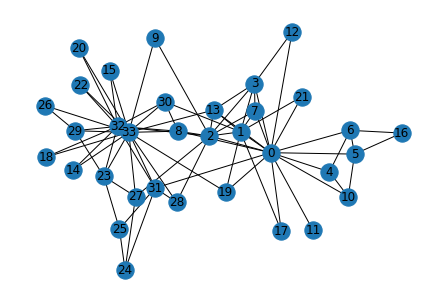

In [26]:
nx.draw(zkc, with_labels=True)

In [9]:
order = sorted(list(zkc.nodes()))
A = to_numpy_matrix(zkc, nodelist=order)
I = np.eye(zkc.number_of_nodes())
A_hat = A + I
A_hat

matrix([[1., 4., 5., ..., 2., 0., 0.],
        [4., 1., 6., ..., 0., 0., 0.],
        [5., 6., 1., ..., 0., 2., 0.],
        ...,
        [2., 0., 0., ..., 1., 4., 4.],
        [0., 0., 2., ..., 4., 1., 5.],
        [0., 0., 0., ..., 4., 5., 1.]])

In [10]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.matrix(np.diag(D_hat))
D_hat

matrix([[43.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 30.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0., 34., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., 22.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., 39.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 49.]])

In [27]:
W_1 = np.random.normal(
    loc=0, scale=1, size=(zkc.number_of_nodes(), 4))
W_2 = np.random.normal(
    loc=0, size=(W_1.shape[1], 2))

In [28]:
def gcn_layer(A_hat, D_hat, X, W):
    return relu(D_hat**-1 * A_hat * X * W)
H_1 = gcn_layer(A_hat, D_hat, I, W_1)
H_2 = gcn_layer(A_hat, D_hat, H_1, W_2)
output = H_2

In [29]:
feature_representations = {
    node: np.array(output)[node] 
    for node in zkc.nodes()}

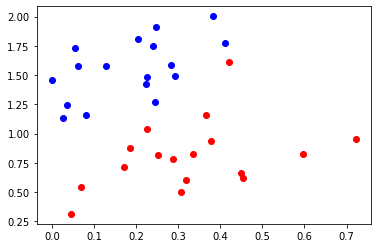

In [30]:
import matplotlib.pyplot as plt

for i in range(len(feature_representations)):
    plt.scatter(
        feature_representations[i][0], 
        feature_representations[i][1], 
        color='red' if zkc.nodes[i]['club'] == 'Mr. Hi' else 'blue')

### 3. Implementation with PyTorch

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.nn.init as init

In [36]:
def norm(A):
    """
    Normalize the Laplacian matrix.
    D^(-1/2) * A * D^(-1/2)
    """
    A += np.eye(A.shape[0]) # add self-loops
    D = np.array(np.sum(A, axis=0))[0] # degree matrix
    D = np.diag(np.power(D, -0.5))
    return D.dot(A).dot(D)

In [37]:
class GraphConvolution(nn.Module):
    """
    Graph convolution layer.
    """
    def __init__(self, input_size, output_size):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, adj, features):
        out = torch.mm(adj, features)
        out = self.linear(out)
        return out

In [38]:
class GCN(nn.Module):
    """
    Graph convolutional network.
    """
    def __init__(self, input_size=34, hidden_size=5, output_size=2):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_size, hidden_size)
        self.gcn2 = GraphConvolution(hidden_size, output_size)
    
    def forward(self, adj, features):
        out = F.relu(self.gcn1(adj, features))
        out = self.gcn2(adj, out)
        return out

In [39]:
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
A = norm(to_numpy_matrix(zkc, nodelist=order))
X = np.eye(zkc.number_of_nodes())
y = np.array([zkc.nodes[i]['club'] == 'Mr. Hi' for i in range(zkc.number_of_nodes())], dtype=np.float32)

A = torch.tensor(A, dtype=torch.float).to(DEVICE)
X = torch.tensor(X, dtype=torch.float).to(DEVICE)
y = torch.tensor(y, dtype=torch.long).to(DEVICE)

In [41]:
net = GCN().to(DEVICE)
loss = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)

def train():
    for epoch in range(EPOCHS):
        out = net(A, X)
        mask = [False if x != 0 and x != 33 else True for x in range(34)] # train on only 2 nodes which we have labels (semi-supervised)
        l = loss(out[mask], y[mask])
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        print(f"epoch: {epoch}, loss: {l.item()}")

In [42]:
train()

epoch: 0, loss: 0.7088981866836548
epoch: 1, loss: 0.6560057997703552
epoch: 2, loss: 0.5796082019805908
epoch: 3, loss: 0.4978311359882355
epoch: 4, loss: 0.40322479605674744
epoch: 5, loss: 0.3315892517566681
epoch: 6, loss: 0.28373634815216064
epoch: 7, loss: 0.24328339099884033
epoch: 8, loss: 0.21116317808628082
epoch: 9, loss: 0.18066678941249847
epoch: 10, loss: 0.15200500190258026
epoch: 11, loss: 0.12609344720840454
epoch: 12, loss: 0.103644959628582
epoch: 13, loss: 0.08590873330831528
epoch: 14, loss: 0.07244366407394409
epoch: 15, loss: 0.06147359684109688
epoch: 16, loss: 0.05261950194835663
epoch: 17, loss: 0.045423343777656555
epoch: 18, loss: 0.03945352882146835
epoch: 19, loss: 0.03436948359012604
epoch: 20, loss: 0.02995678223669529
epoch: 21, loss: 0.02611272595822811
epoch: 22, loss: 0.02279094234108925
epoch: 23, loss: 0.019796986132860184
epoch: 24, loss: 0.01668589934706688
epoch: 25, loss: 0.013307715766131878
epoch: 26, loss: 0.009838209487497807
epoch: 27, los

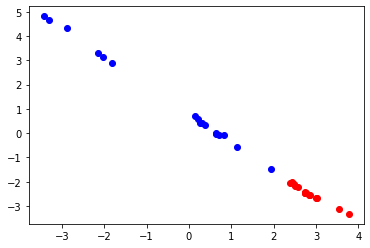

In [43]:
r = net(A, X).cpu().detach().numpy()
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(34):
    plt.scatter(r[i][0], r[i][1], color="r" if y[i] == 0 else 'b')
plt.show()